# Parareal Iterations

This notebook explains how to use the Parareal scheme in combination with the end-to-end model of the master's thesis “Wave propagation aided by Deep Learning” by Luis Kaiser, supervised by Prof. Tsai (University of Texas Austin) and Prof. Klingenberg (University of Wuerzburg), in practice. More information about the algorithm can be found in my [code](https://github.com/utkaiser/masterthesis_code) or [writeup](https://github.com/utkaiser/masterthesis_writing).

First, make sure that you have install all necessary libraries specified in `requirements.txt` using `pip` or `pip3` depending on your setup by running the command below.

In [ ]:
!pip3 install --upgrade pip
!pip3 install -r requirements.txt

We make this notebook easier to read with less complex dependencies in the code than compared to the implementation in `parareal/parareal_scheme_training.py`. The main difference is that this notebook is used to evaluate the performance of the trained end-to-end model, while in the other approach, we train the model during the Parareal iterations. This has the key benefit that the model is able to better leverage the Parareal scheme.

For this, we first input the velocity profile and an initial condition $u$ and $u_t$. Next, we take a first guess by applying the pre-trained end-to-end model multiple times (defined by variable `n_it`) to advance the wave front. We then use this information to enhance our solution according to the Parareal scheme. The thesis contains detailed information about the algorithm.
The coarse solver $G_{\Delta t^\star}$ and the fine solver $F_{\Delta t^\star}$ solve the wave equation numerically for a time step $\Delta t^\star$. We further define $\mathfrak{u}_{n+1} := F_{\Delta t^\star} \mathfrak{u}_n$ with $\mathfrak{u}_{n+1} := (u, u_t)$.

The Parareal scheme follows as:
\begin{equation}
    \mathfrak{u}_{n+1}^{k+1} = \mathcal{I} G_{\Delta t^\star} \mathcal{R} \mathfrak{u}_n^{k+1} + [F_{\Delta t^\star} \mathfrak{u}_n^k - \mathcal{I} G_{\Delta t^\star} \mathcal{R} \mathfrak{u}_n^k], k = 0,1,...
\end{equation}
with the starting condition
\begin{equation}
    \mathfrak{u}_{n+1}^0 := \mathcal{I} G_{\Delta t^\star} \mathcal{R} \mathfrak{u}_n^0, n \in \mathbb{N}.
\end{equation}

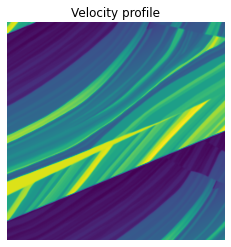

Solve wave equation using pseudo-spectral method.
Performing initial guess.
Performing Parareal iteration 1.
Performing Parareal iteration 2.
Comparing results for 10 iterations of pseudo-spectral method (first row) vs end-to-end model (second row), and Parareal scheme (last rows).


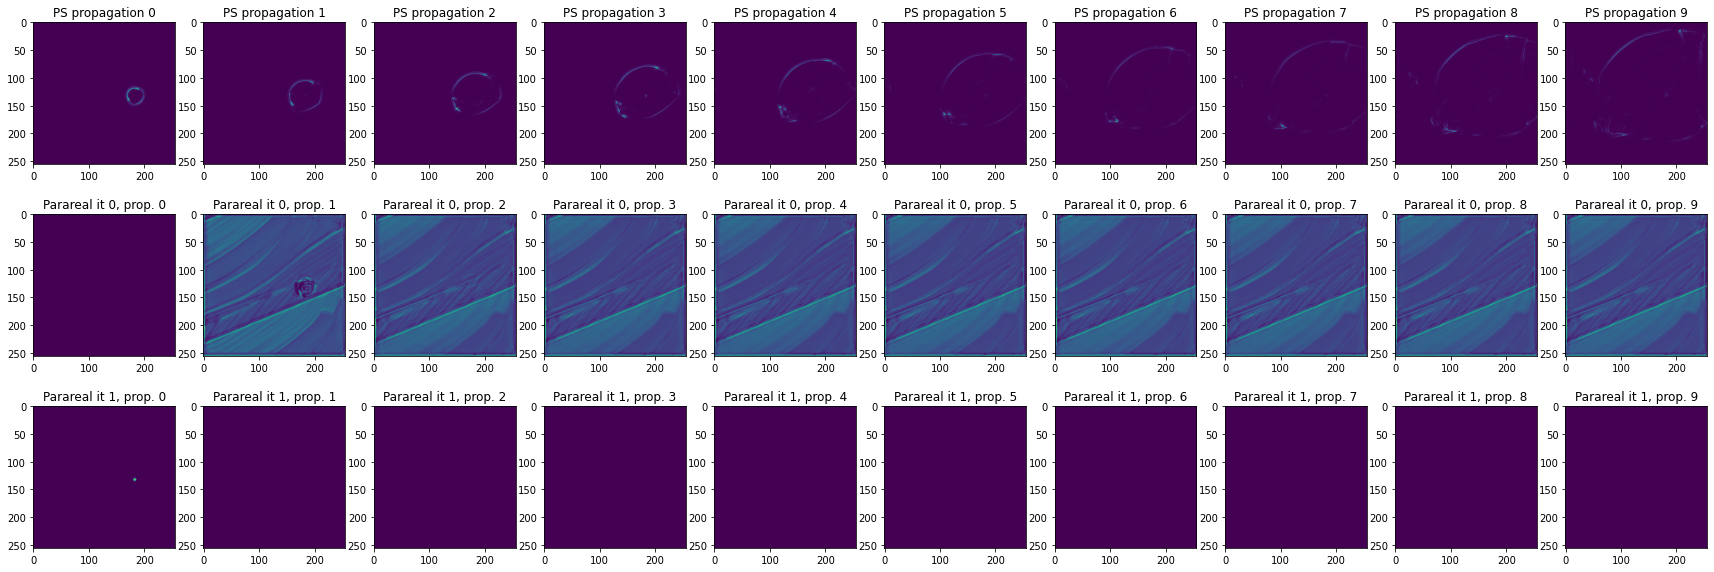

In [1]:
from matplotlib import pyplot as plt
from generate_data.change_wave_arguments import WaveSol_from_EnergyComponent_tensor, WaveEnergyField_tensor
from generate_data.initial_conditions import initial_condition_gaussian
from notebook_workflow.utils import get_velocity_model, pseudo_spectral_solutions, visualize_parareal
import sys
from models.model_end_to_end import get_model
sys.path.append("..")
from generate_data.utils_wave_propagate import one_iteration_pseudo_spectral_tensor
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from parareal.param_settings import get_params


def get_parareal_solutions(
        vel_data_path = "crop_test.npz",
        res = 256,
        n_it = 10,
        n_parareal = 2,
        boundary_conditions = "periodic",
        model_res = 256,
        model_scaling_factor = 2,
        model_path = "saved_model_test.pt"
):
    param_dict = get_params("0")
    model = get_model(
        model_path = model_path,
        param_dict = param_dict,
        res_scaler = model_scaling_factor,
        model_res = model_res,
    )
    model.eval()
    vel = get_velocity_model(vel_data_path)

    # computing initial condition using gaussian pulse (switch to pytorch tensor if needed)
    u_energy = initial_condition_gaussian(
        torch.from_numpy(vel),
        resolution=res,
        boundary_condition=boundary_conditions,
        mode="energy_components",
        optimization="none",
        res_padded=res
    )

    ps_sol_tensor = pseudo_spectral_solutions(u_energy, vel, n_it,
                                       param_dict["f_delta_x"],
                                       param_dict["f_delta_t"],
                                       param_dict["delta_t_star"])

    with torch.no_grad():
        parareal_tensor = parareal_scheme(
            model,
            torch.cat([u_energy, torch.from_numpy(vel).unsqueeze(dim=0).unsqueeze(dim=0)], dim=1),
            n_parareal,
            n_it,
            boundary_conditions
        )


    print(f"Comparing results for {n_it} iterations of pseudo-spectral method (first row) vs "
          f"end-to-end model (second row), and Parareal scheme (last rows).")

    visualize_parareal(
        ps_sol_tensor,
        parareal_tensor,
        n_parareal,
        n_it,
        param_dict["f_delta_x"],
        vel
    )

    plt.show()



def parareal_scheme(
        model,
        u_0,
        n_parareal,
        n_snapshots,
        boundary_conditions
):

    u_n = u_0.clone()
    vel = u_0[:,3].clone().unsqueeze(dim=0)
    batch_size, channel, width, height = u_n.shape
    if boundary_conditions == "absorbing":
        width, height = width * 2, height * 2

    # create tensor to save results during iterations; in "absorbing" boundary case,
    # we use padding because of pseudo-spectral method
    big_tensor = torch.zeros([n_parareal+1, n_snapshots, batch_size, channel - 1, width, height])

    # initial guess, first iteration without parareal
    print(f"Performing initial guess.")
    for n in range(n_snapshots-1):
        u_n1 = model(u_n)
        big_tensor[0,n+1] = u_n1
        u_n = torch.cat((u_n1, vel), dim=1)

    # parareal iterations: k = 1, 2, ...
    for k in range(1,n_parareal+1):
        print(f"Performing Parareal iteration {k}.")

        big_tensor[k,0] = u_0[0,:3].clone()
        parareal_terms = get_parareal_terms(
            model, big_tensor[k].clone(),
            n_snapshots, vel.clone()
        )
        new_big_tensor = torch.zeros([n_snapshots, batch_size, channel - 1, width, height])
        new_big_tensor[0] = u_0[:, :3].clone()

        for n in range(n_snapshots-1):
            u_n_k1 = torch.cat((new_big_tensor[n], vel), dim=1)
            u_n1_k1 = model(u_n_k1) + parareal_terms[n]
            new_big_tensor[n+1] = u_n1_k1

        if k < n_parareal:
            big_tensor[k+1] = new_big_tensor.clone()

    return big_tensor


def get_parareal_terms(
        model,
        big_pseudo_tensor,
        n_snapshots,
        vel
):
    '''
    Parameters
    ----------
    model : (pytorch.Model) end-to-end model to advance a wave front
    big_pseudo_tensor : (pytorch tensor) tensor containing previous solution (high resolution due to pseudo-spectral cropping)
    n_snapshots : (int) number of iterations (number of iterations with length dt_star)
    vel : (pytorch tensor) velocity profile

    Returns
    -------
    get Parareal terms that can be computed in parallel
    '''

    with torch.no_grad():
        parareal_terms = torch.zeros(big_pseudo_tensor.shape)
        for s in range(n_snapshots):
            parareal_terms[s] = compute_parareal_term(model, torch.cat([big_pseudo_tensor[s], vel], dim=1))
    return parareal_terms


def compute_parareal_term(
        model,
        u_n_k
):
    '''
    Parameters
    ----------
    model : (pytorch.Model) end-to-end model to advance a wave front
    u_n_k : (pytorch tensor) current wave field

    Returns
    -------
    difference between Parareal terms of right-hand side of main Parareal equation (see thesis)
    '''

    res_fine_solver = one_iteration_pseudo_spectral_tensor(u_n_k)
    res_model = model(u_n_k)

    return res_fine_solver.to(device) - res_model.to(device)


get_parareal_solutions()